<a href="https://colab.research.google.com/github/marcosfmmota/RL-mo436/blob/main/notebooks/project2_mo436.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 2 - Reinforcement Learning - MO436

### Group 11 (Alex Silva Torres, Darlinne Hubert Palo Soto, Lucas Pini Tanabe, Marcos Felipe de Menezes Mota)


## Problema

Nesse projeto iremos analisar o comportamento de algoritmos de Deep Reinforcement Learning para jogos de Atari. O enfoque vai ser na versão de Atari do jogo Pacman. 

A utilização de algoritmos de reinforcement learning em jogos de Atari foi o primeiro breakthrough da utilização de métodos de deep learning com RL, resultado no estudo da área de Deep Reinforcement Learning [1]. No entanto, tais implementações, em geral, utilizam treinamento por várias dias em computadores com altas recursos computacionais para atingir o estado da arte.

Nesse projeto iremos fazer a análise dos algoritmos DQN (Deep Q-Networks) [1] e PPO (Proximal Policy Optimization) [2] na versão de Atari do Pacman. O jogo MsPacman foi um dos que obteve pior performance comparado a humanos em [1], ou seja, ainda é um ambiente interessante para exploração de melhorias.

## Formulação MDP
Uma das principais vantagens da utilização de Deep RL é a capacidade de utilizar como entrada de dados, ou seja formulação do estado, espaços de alta dimensionalidade. Isso, reduz a necessidade da engenharia de features, que é comum em aproximadores de função lineares. No caso de jogos de Atari, o algortimo pode ser treinado com os pixels de tela do jogo [1]. O espaço de ação é as combinações de botões que podem ser utilizados em Atari [1]. No domínio de jogos de Atari há um pré-processamento para deixar a amostragem mais eficiente para algoritmos de Deep RL.  

### Pré-processamento
Os jogos de Atari utilizando o emulador Arcade Learning Environment library obtem as capturas de tela do jogo no formato $(210,160, 3)$ onde temos uma tela RGB de 210x160 [3]. O pré-processamento padrão é definido em [1] e é feita uma redução do tamanho da tela para 84x84 e em escala de cinza, ou seja, $(84, 84, 1)$. Frames à 60Hz por segundo é uma taxa alta e muitos desses frames não informam o real estado do jogo para o algoritmo, por exemplo direção de movimento de inimigos no Pacman. Por isso, é feito *frame skipping* [3] onde apenas alguns frames são selecionado, escolhendo os frames onde ocorre maior mudançã considerando outros frames adjacentes no tempo. Após esse processo é escolhido uma quantidade de frames chamada em [1] de $\phi$ *length*, para representar o estado para a rede neural [3], em geral esse $\phi$ *length* é 4.

### Estados
No MDP para jogos de Atari, o estado $S$ é um conjunto de pixels de tamanho $(84, 84, 4)$ resultado do pré-processamento aplicado as capturas de tela fornecidas por um emulador.

### Ações
As ações possíveis são os 18 possíveis comandos do Atari, 8 direcionais vezes botão pressionado adicionado de não-ação. No entanto para o jogo do MsPacman do Atari são apenas nove ações, pois não há possibilidade de movimentação na diagonal.

### Recompensa
A recompensa para cada ação é recebida do emulador, junto com o numero de vidas no caso de jogos com esse recurso [1]. No entanto, para avaliar algoritmos em diferentes jogos, o score do jogo informado é normalizado para ficar dentro do intervalo $[-1, 1]$. Tal informação é obtida para qualquer frame do jogo.

### Transição de Estado
A transição de estado é percebida pela mudança no conjunto de pixels da tela após uma ação. Nos ambientes de Atari implementados pelo *OpenAI GYM*, e utilizados no projeto, uma única ação é feita em 4 frames em sequência de maneira aleatória para propagar o efeito de uma ação e introduzir estocasticidade. 

### Ambiente
A formulação do ambiente de jogos em geral é episódica e determinística. Porém, como foi falado na seção de transição de estados, o ambiente é episódico mas a forma que as ações ocorrem no frames, tornam o ambiente estocástico.

## Bibliotecas Utilizadas

Os algoritmos utilizados são provenientes do Stable-Baselines3 que é a versão mais nova do Stable-Baselines indicado no disciplina. O Stable-Baseline3 utiliza como ambientes interfaces do OpenAI Gym e o framework Pytorch. Inicialmente tentamos implementar a versão da DQN nos tutoriais de pytorch mas a modelagem não era transponível para ambientes de Atari como o Stable-Baselines3.

[OpenAI Gym](https://gym.openai.com/)
[Stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html) 
[Pytorch Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [6]:
!pip install stable-baselines3[extra]

## Funções Adicionais




In [31]:
# Video Recorder
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.env_util import make_atari_env

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = make_atari_env(env_id)
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

## Método off-policy (DQN)

DQN é um método off-policy onde os dados são passados por um rede neural convolucional para estimativa de o valor do par estado ação $Q(s,a)$ e com um politíca $\epsilon -greedy$ obter um política ótima para um problema. Sua implementação resolve problemas clássicos de convergência de métodos que utilizam redes neurais para problemas de RL. DQN introduziu experience replay e atualização iterativa de target [1]. O experience replay remove a alta dependência entre os dados observados. E a atualização iterativa mantém outra rede que é treinada paralelamente, chamada *target network*. A utilização da *target network* que ajuda a guiar a rede treinada atualmente caracteriza a DQN como um método off-policy. Afunção objetivo optmizada pela rede é:
$$ L_i(\theta_i) = {\mathbb{E}}_{(s,a,r, s')}[(r + \gamma\max_{a'}Q(s',a';\theta_i^-) - Q(s,a; \theta_i))^2] $$

### Modelo Default
O experience replay padrão utilizado em SB3 é 1M, mas tal alocação é acima da quota do google colab. Além disso, o número total de passos acima de 200000 também estoura a alocação de tempo do colab. Por isso utilizamos buffer_size de 500000 e total_timesteps de 200000. 

In [3]:
import gym
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy, CnnPolicy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.atari_wrappers import WarpFrame, ClipRewardEnv, AtariWrapper

BUFFER_SIZE = 500000
TOTAL_TIMESTEPS = 100000

env = make_atari_env('MsPacman-v0')

In [9]:
model_dqn = DQN(CnnPolicy, env, buffer_size=BUFFER_SIZE)

In [ ]:
model_dqn.learn(total_timesteps=TOTAL_TIMESTEPS)
model_dqn.save(f"dqn_model/dqn_mspacman-default-{BUFFER_SIZE}-{TOTAL_TIMESTEPS}")

In [29]:
loaded_dqn_model = DQN.load(f"dqn_model/dqn_mspacman-default-{BUFFER_SIZE}-{TOTAL_TIMESTEPS}")


In [30]:
avg, std = evaluate_policy(loaded_dqn_model, env_eval, n_eval_episodes=100)
print(f"Reforço médio para modelo default {avg} +/- {std}")

Reforço médio para modelo default 20.639999389648438 +/- 15.395791053771973


In [ ]:
# Apaga o modelo default carregado pois passos adicionais estouram memória do colab
del loaded_dqn_model

### Exploração de paramêtros

In [14]:
BUFFER_SIZE = 10000
TOTAL_TIMESTEPS = 50000
learning_rate = [0.0001, 0.001, 0.01]
gamma = [0.99, 0.9, 0.85]
env = make_atari_env('MsPacman-v0')
model_dqn = DQN(CnnPolicy, env, buffer_size=BUFFER_SIZE)

In [18]:
do_param_search = False

if do_param_search:
  for lr in learning_rate:
    for g in gamma:
      env = make_atari_env('MsPacman-v0')
      model_dqn = DQN('CnnPolicy', env, buffer_size=BUFFER_SIZE, learning_rate=lr, gamma=g)
      model_dqn.learn(total_timesteps=TOTAL_TIMESTEPS)
      model_dqn.save(f"dqn_model/dqn_mspacman-lr-{lr}-g-{g}")

/usr/local/lib/python3.6/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'dqn_model' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


### Avaliação de Modelos

In [23]:
from stable_baselines3.common.evaluation import evaluate_policy
env_eval = make_atari_env('MsPacman-v0')
do_param_eval = True
evaluation = {}
learning_rate = [0.0001, 0.001]
if do_param_eval:
  for lr in learning_rate:
    for g in gamma:
      loaded_dqn_model = DQN.load(f"dqn_model/dqn_mspacman-lr-{lr}-g-{g}")
      evaluation[(lr, g)] = evaluate_policy(loaded_dqn_model, env_eval, n_eval_episodes=100)

{(0.0001, 0.99): (2.34, 3.265639), (0.0001, 0.9): (6.81, 9.433658), (0.0001, 0.85): (6.92, 9.683678), (0.001, 0.99): (3.04, 4.2377357), (0.001, 0.9): (2.34, 3.2687), (0.001, 0.85): (3.71, 5.0720706)}


In [25]:
np.max(evaluation)

{(0.0001, 0.85): (6.92, 9.683678),
 (0.0001, 0.9): (6.81, 9.433658),
 (0.0001, 0.99): (2.34, 3.265639),
 (0.001, 0.85): (3.71, 5.0720706),
 (0.001, 0.9): (2.34, 3.2687),
 (0.001, 0.99): (3.04, 4.2377357)}

Com os resultado obtidos da avaliação dos hiperparametros podemos ver que dos fatores explorados o que obteve maior média foi **learning_rate=0.0001** (o mesmo do default), mas $\gamma = 0.85$. Portanto privilegiar reforços iniciais tras melhor resultado em média para avaliações em pouco episodios.  

### Grava Melhor modelo

In [ ]:
best_dqn_model = DQN.load(f"dqn_model/dqn_mspacman-default-{BUFFER_SIZE}-{TOTAL_TIMESTEPS}")

In [8]:
record_video('MsPacman-v0', best_dqn_model, video_length=800, prefix='dqn-mspacman-default-')

Saving video to  /content/videos/dqn-mspacman-default--step-0-to-step-800.mp4


In [10]:
show_videos('videos', 'dqn-mspacman-default')

## Método on-policy (PPO)

PPO é um método de otimização de política baseado em otimização *trust region*, que alterna entre amostragem de dados através de interação com ambiente e otimização de uma função "substituta" [2]. PPO é considerado um aprimoramento de do método TRFO com ideias do A2C. Sua principal vantagem é a capacidade de funcionar com ambientes em paralelo, por isso o uso da variável *n_envs* na definição de ambiente do código abaixo. 

A formulação de uma função de *clipping* tornou o PPO um método mais eficiente de ser treinado em relação ao TRFO. Enquanto TRFO utiliza KL-divergence para verificar quando a atualização de um política está muito distante do esperando, PPO define um intervalo linear e quanto função de vantagem $A$ passa desse intervalo ela fica constante. Isso torna o processo de treinamento mais estável e evita mudanças excessivas na política. Tal comportamento pode ser visto na imagem abaixo.

A função de CLIP para otimização de políticas no PPO é definida por:
$$L^{CLIP}(\theta) = {\mathbb{E}_t[\min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]}$$

Esse *clip range* é um paramêtro importante para métodos PPO e por isso é valor que iremos testar com variações para o ambiente do MsPacman.

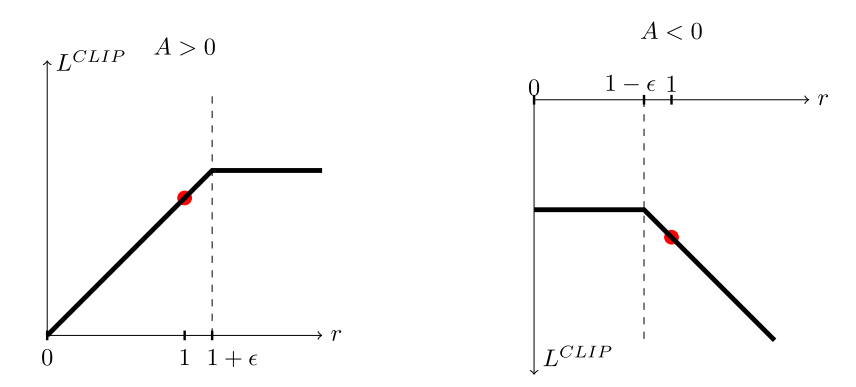

### Modelo Default

In [8]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

TOTAL_TIMESTEPS = 100000
# Parallel environments
env = make_atari_env('MsPacman-v0', n_envs=4)
model_ppo = PPO('CnnPolicy', env)

In [ ]:
model_ppo.learn(total_timesteps=TOTAL_TIMESTEPS)
model_ppo.save(f"ppo_model/ppo_mspacman-default-t-{TOTAL_TIMESTEPS}")

In [14]:
loaded_model_ppo = PPO.load(f"ppo_model/ppo_mspacman-default-t-{TOTAL_TIMESTEPS}")

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy
env_eval = make_atari_env('MsPacman-v0')
mean_reward, std_reward = evaluate_policy(loaded_model_ppo, env_eval, n_eval_episodes=100)

print(f"Modelo Default PPO - Ganho médio:{mean_reward:.2f} +/- {std_reward:.2f}")

Modelo Default PPO - Ganho médio:4.35 +/- 3.77


### Exploração de paramêtros

In [11]:
do_param_search = False
learning_rate = [0.0003, 0.003, 0.03]
clip_range = [0.2, 0.4, 0.6, 0.8]
TIMESTEPS = 50000
# Treina os modelos para todos os possíveis hyperparamêtros
if do_param_search:
  for lr in learning_rate:
    for clip in clip_range:
      env = make_atari_env('MsPacman-v0', n_envs=4)
      model_ppo = PPO('CnnPolicy', env, learning_rate=lr, clip_range=clip)
      model_ppo.learn(total_timesteps=t)
      model_ppo.save(f"ppo_model/ppo_mspacman-{lr}-{clip}")

### Avaliação de Modelos

In [22]:
from stable_baselines3.common.evaluation import evaluate_policy
env_eval = make_atari_env('MsPacman-v0')
do_param_eval = True
evaluation = {}

if do_param_eval:
  for lr in learning_rate:
    for clip in clip_range:
      loaded_ppo_model = PPO.load(f"ppo_model/ppo_mspacman-{lr}-{clip}")
      evaluation[(lr, clip)] = evaluate_policy(loaded_ppo_model, env_eval, n_eval_episodes=200)

In [25]:
evaluation

{(0.0003, 0.2): (10.61, 6.422453),
 (0.0003, 0.4): (2.005, 2.8008883),
 (0.0003, 0.6): (7.385, 9.226417),
 (0.0003, 0.8): (1.985, 2.8008523),
 (0.003, 0.2): (17.3, 11.823282),
 (0.003, 0.4): (12.685, 11.024779),
 (0.003, 0.6): (11.04, 8.232157),
 (0.003, 0.8): (13.625, 9.569972),
 (0.03, 0.2): (2.31, 3.260966),
 (0.03, 0.4): (2.305, 3.2529948),
 (0.03, 0.6): (2.37, 3.3034983),
 (0.03, 0.8): (3.705, 2.7978518)}

A partir da avaliação dos 12 modelos com diferente hiperparâmetros, podemos observar que o learning rate de 0.003 e clip range de 0.2 foi o melhor modelo em média. Clip range de 0.2 é o padrão do SB3 PPO e o reportado no artigo original com melhor resultado em benchmark [2]. O valor de lr de 0.003 indica que para o MsPacman é possível deixar a descida do gradiente maior na otimização sem degradar a performance do algoritmo.    

In [26]:
best_ppo_model = PPO.load(f"ppo_model/ppo_mspacman-0.003-0.2")

In [27]:
record_video('MsPacman-v0', best_ppo_model, video_length=800, prefix=f'ppo_mspacman-best-')

Saving video to  /content/videos/ppo_mspacman-best--step-0-to-step-800.mp4


In [32]:
show_videos('videos', 'ppo-mspacman-best-')

## Discussão

Para o problema do Pacman de Atari, tanto o método DQN como PPO mostraram ser eficientes para obtenção de uma estratégia inicial em casos de recursos reduzidos. PPO tem a grande vantagem de permitir treinamento em ambientes paralelos e utilização de pouca memória RAM. A DQN no entanto foi que obteve melhor performance no geral e visualmente é que apresenta melhores resultados. Pois em vídeo é possíve ver a MsPacman com estratégia focada em evitar os fantasmas do jogo e até aproveitar bonus quando eles estão congelados. No quisito computacional, DQN é bem mais lenta em treinamento e utiliza muito memória RAM. O valor padrão de experience replay do DQN (1M) acaba com os recursos do google colab impedindo maior experimentação. Visualmente o agente MsPacman PPO mostrou uma estratégia voltada para conseguir o máximo de moedas e mostrou não evitar os fantasmas quando muito próximo. Com os testes feitos, podemos afirmar que DQN é o melhor método para situações com muita memória e poder de processamento. Já o PPO, permite maior eficiência em recursos e permite mais experimentação para otimização de hiperparâmetros, sendo uma opção excelente para exploração de métodos de RL para um problema.       

## Referências

[1] V. Mnih et al., “Human-level control through deep reinforcement learning,” Nature, vol. 518, no. 7540, pp. 529–533, 2015, doi: 10.1038/nature14236.

[2] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, “Proximal policy optimization algorithms,” arXiv, pp. 1–12, 2017.

[3] [Frame Skipping and Pre-Processing for Deep Q-Networks on Atari 2600 Games](https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/)